In [585]:
#bootstrap the OIS discount factor and plot the discount curve for T [0,30]
#Using the IRS, bootstrap the lIBOR discount factor D(0,T) and plot for t [0,30]
#Calculate: 1X1, 1X2, 1X3, 1X5, 1X10 |5X1, 5X2, 5X3, 5X5, 5X10
#10X1, 10X2, 10X3, 10X5, 10X10


In [62]:
import numpy as np
import pandas as pd
import scipy.stats as stat
from scipy.interpolate import interp1d
import statistics
from statistics import NormalDist
import matplotlib.pyplot as plt
from scipy.optimize import least_squares


In [64]:
irr_data = pd.read_excel("IR Data.xlsx",sheet_name="IRS")
ois_data=pd.read_excel("IR Data.xlsx",sheet_name="OIS")

In [66]:
irr_data=irr_data.iloc[:,:3]
ois_data=ois_data.iloc[:,:3]

In [68]:
def split_column(tenor):
    if "y" in tenor:
        years=float(tenor.replace("y",""))
        return float(years)
    elif "m" in tenor:
        months=float(tenor.replace("m",""))
        return months*30/360
    else:
        return 0

irr_data["years"]=irr_data["Tenor"].apply(split_column)
ois_data["years"]=ois_data["Tenor"].apply(split_column)

In [70]:
#OIS Discount Factor
sum_of_df=0
list_of_df=0
for index,row in ois_data.iterrows():
    df=0
    if index==0: #6m
        df=(1/(1+0.5*ois_data["Rate"][index]))
    elif index==5:#5Y
        df=(1-(sum_of_df*ois_data["Rate"][index]))/(1+ois_data["Rate"][index])
    elif index==6:#7Y
        df=(1-(sum_of_df+1.5*ois_data["df"].loc[5])*ois_data["Rate"].loc[6])/(1.5*ois_data["Rate"].loc[6]+1)
    elif index==7: #10Y
        df=(1-(sum_of_df+1.5*ois_data["df"].loc[5]+2.5*ois_data["df"].loc[6])*ois_data["Rate"].loc[7])/(2*ois_data["Rate"].loc[7]+1)
    elif index==8: #15y
        df=(1-(sum_of_df+1.5*ois_data["df"].loc[5]+2.5*ois_data["df"].loc[6]+4*ois_data["df"].loc[7])*ois_data["Rate"].loc[8])/(3*ois_data["Rate"].loc[8]+1)
    elif index==9: #20y
        df=(1-(sum_of_df+1.5*ois_data["df"].loc[5]+2.5*ois_data["df"].loc[6]+4*ois_data["df"].loc[7]+5*ois_data["df"].loc[8])*ois_data["Rate"].loc[9])/(3*ois_data["Rate"].loc[9]+1)
    elif index==10: #20y
        df=(1-(sum_of_df+1.5*ois_data["df"].loc[5]+2.5*ois_data["df"].loc[6]+4*ois_data["df"].loc[7]+5*ois_data["df"].loc[8]+7.5*ois_data["df"].loc[9])*ois_data["Rate"].loc[10])/(5.5*ois_data["Rate"].loc[10]+1)   
    elif index ==1:
        df=(1/(1+ois_data["Rate"][index]))
        sum_of_df+=df
    else:
        df=(1-(sum_of_df*ois_data["Rate"][index]))/(1+ois_data["Rate"][index])
        sum_of_df+=df
    ois_data.at[index,"df"]=df
ois_data

,Tenor,Product,Rate,years,df
0,6m,OIS,0.00250,0.5,0.998752
1,1y,OIS,0.00300,1.0,0.997009
2,2y,OIS,0.00325,2.0,0.993531
3,3y,OIS,0.00335,3.0,0.990015
4,4y,OIS,0.00350,4.0,0.986117
5,5y,OIS,0.00360,5.0,0.982184
6,7y,OIS,0.00400,7.0,0.972406
7,10y,OIS,0.00450,10.0,0.955977
8,15y,OIS,0.00500,15.0,0.927611
9,20y,OIS,0.00525,20.0,0.900076


In [72]:
tenors=[0.5,1,2,3,4,5,7,10,15,20,30]

In [74]:
ois_df=interp1d(tenors,ois_data["df"])
ois_df

In [76]:
#LIBOR Discount Factor
sum_of_df_libor=0
for index,row in ois_data.iterrows():
    df_libor=0
    if index==0: #6m
        df=(1/(1+0.5*ois_data["Rate"][index]))
    elif index==5:#5Y
        df=(1-(sum_of_df*ois_data["Rate"][index]))/(1+ois_data["Rate"][index])
    elif index==6:#7Y
        df=(1-(sum_of_df+1.5*ois_data["df"].loc[5])*ois_data["Rate"].loc[6])/(1.5*ois_data["Rate"].loc[6]+1)
    elif index==7: #10Y
        df=(1-(sum_of_df+1.5*ois_data["df"].loc[5]+2.5*ois_data["df"].loc[6])*ois_data["Rate"].loc[7])/(2*ois_data["Rate"].loc[7]+1)
    elif index==8: #15y
        df=(1-(sum_of_df+1.5*ois_data["df"].loc[5]+2.5*ois_data["df"].loc[6]+4*ois_data["df"].loc[7])*ois_data["Rate"].loc[8])/(3*ois_data["Rate"].loc[8]+1)
    elif index==9: #20y
        df=(1-(sum_of_df+1.5*ois_data["df"].loc[5]+2.5*ois_data["df"].loc[6]+4*ois_data["df"].loc[7]+5*ois_data["df"].loc[8])*ois_data["Rate"].loc[9])/(3*ois_data["Rate"].loc[9]+1)
    elif index==10: #20y
        df=(1-(sum_of_df+1.5*ois_data["df"].loc[5]+2.5*ois_data["df"].loc[6]+4*ois_data["df"].loc[7]+5*ois_data["df"].loc[8]+7.5*ois_data["df"].loc[9])*ois_data["Rate"].loc[10])/(5.5*ois_data["Rate"].loc[10]+1)   
    elif index ==1:
        df=(1/(1+ois_data["Rate"][index]))
        sum_of_df+=df
    else:
        df=(1-(sum_of_df*ois_data["Rate"][index]))/(1+ois_data["Rate"][index])
        sum_of_df+=df
    ois_data.at[index,"df"]=df
ois_data

,Tenor,Product,Rate,years,df
0,6m,OIS,0.00250,0.5,0.998752
1,1y,OIS,0.00300,1.0,0.997009
2,2y,OIS,0.00325,2.0,0.980681
3,3y,OIS,0.00335,3.0,0.976814
4,4y,OIS,0.00350,4.0,0.972373
5,5y,OIS,0.00360,5.0,0.968098
6,7y,OIS,0.00400,7.0,0.956876
7,10y,OIS,0.00450,10.0,0.938731
8,15y,OIS,0.00500,15.0,0.908902
9,20y,OIS,0.00525,20.0,0.880929


In [78]:
prev_rate=[]
for index,row in irr_data.iterrows():
    if index==0:
        libor_6mlibor=irr_data["Rate"][index]
        prev_rate.append(libor_6mlibor)
    elif index==1:
        N=tenors[index]
        S=irr_data["Rate"][index]
        PV_fix=(ois_df(np.arange(N,0,-0.5)).sum())*0.5*S
        PV_flt=lambda x: ois_df(0.5)*0.5*prev_rate[-1]+ois_df(1)*0.5*x
        residual_func = lambda x: PV_flt(x) - PV_fix
        result = least_squares(residual_func, prev_rate[-1])
        new_rate = result.x[0] #L6m,1y
        prev_rate.append(new_rate)
    elif index==2:
        N=tenors[index]
        S=irr_data["Rate"][index]
        PV_fix=(ois_df(np.arange(N,0,-0.5)).sum())*0.5*S
        PV_flt=lambda x: ois_df(0.5)*0.5*(prev_rate[0])\
        +ois_df(1)*0.5*new_rate+ois_df(1.5)*x/(x+2)+ois_df(2)*x/2
        residual_func = lambda x: PV_flt(x) - PV_fix
        result = least_squares(residual_func, prev_rate[-1])
        new_rate = result.x[0] #L1,2
        prev_rate.append(new_rate)
    elif index==3:
        N=tenors[index]
        S=irr_data["Rate"][index]
        PV_fix=(ois_df(np.arange(N,0,-0.5)).sum())*0.5*S
        PV_flt=lambda x: ois_df(0.5)*0.5*(prev_rate[0])\
        +ois_df(1)*0.5*prev_rate[1]\
        +ois_df(1.5)*prev_rate[2]/(prev_rate[2]+2)\
        +ois_df(2)*prev_rate[2]/2\
        +ois_df(2.5)*x/(x+2)\
        +ois_df(3)*x/2
        residual_func = lambda x: PV_flt(x) - PV_fix
        result = least_squares(residual_func, prev_rate[-1])
        new_rate = result.x[0] #L2,3
        prev_rate.append(new_rate)   
    elif index==4:
        N=tenors[index]
        S=irr_data["Rate"][index]
        PV_fix=(ois_df(np.arange(N,0,-0.5)).sum())*0.5*S
        PV_flt=lambda x: ois_df(0.5)*0.5*(prev_rate[0])\
              +ois_df(1)*0.5*prev_rate[1]\
              +ois_df(1.5)*prev_rate[2]/(prev_rate[2]+2)\
              +ois_df(2)*prev_rate[2]/2\
              +ois_df(2.5)*prev_rate[3]/(prev_rate[3]+2)\
              +ois_df(3)*prev_rate[3]/2\
              +ois_df(3.5)*x/(x+2)\
              +ois_df(4)*x/2
        residual_func = lambda x: PV_flt(x) - PV_fix
        result = least_squares(residual_func, prev_rate[-1])
        new_rate = result.x[0] #L3,4
        prev_rate.append(new_rate)  
    elif index==5:
        N=tenors[index]
        S=irr_data["Rate"][index]
        PV_fix=(ois_df(np.arange(N,0,-0.5)).sum())*0.5*S
        PV_flt=lambda x: ois_df(0.5)*0.5*(prev_rate[0])\
              +ois_df(1)*0.5*prev_rate[1]\
              +ois_df(1.5)*prev_rate[2]/(prev_rate[2]+2)\
              +ois_df(2)*prev_rate[2]/2\
              +ois_df(2.5)*prev_rate[3]/(prev_rate[3]+2)\
              +ois_df(3)*prev_rate[3]/2\
              +ois_df(3.5)*prev_rate[4]/(prev_rate[4]+2)\
              +ois_df(4)*prev_rate[4]/2\
              +ois_df(4.5)*x/(x+2)\
              +ois_df(5)*x/2
        residual_func = lambda x: PV_flt(x) - PV_fix
        result = least_squares(residual_func, prev_rate[-1])
        new_rate = result.x[0] #L4,5
        prev_rate.append(new_rate)  
    elif index==6:
        N=tenors[index]
        S=irr_data["Rate"][index]
        PV_fix=(ois_df(np.arange(N,0,-0.5)).sum())*0.5*S
        PV_flt=lambda x: ois_df(0.5)*0.5*(prev_rate[0])\
              +ois_df(1)*0.5*prev_rate[1]\
              +ois_df(1.5)*prev_rate[2]/(prev_rate[2]+2)\
              +ois_df(2)*prev_rate[2]/2\
              +ois_df(2.5)*prev_rate[3]/(prev_rate[3]+2)\
              +ois_df(3)*prev_rate[3]/2\
              +ois_df(3.5)*prev_rate[4]/(prev_rate[4]+2)\
              +ois_df(4)*prev_rate[4]/2\
              +ois_df(4.5)*prev_rate[5]/(prev_rate[5]+2)\
              +ois_df(5)*prev_rate[5]/2\
              +ois_df(5.5)*x/(3*x+2)\
              +ois_df(6)*x/(2*x+2)\
              +ois_df(6.5)*x/(x+2)\
              +ois_df(7)*x/2
        residual_func = lambda x: PV_flt(x) - PV_fix
        result = least_squares(residual_func, prev_rate[-1])
        new_rate = result.x[0] #L5,7
        prev_rate.append(new_rate) 
    elif index==7:
        N=tenors[index]
        S=irr_data["Rate"][index]
        PV_fix=(ois_df(np.arange(N,0,-0.5)).sum())*0.5*S
        PV_flt=lambda x: ois_df(0.5)*0.5*(prev_rate[0])\
              +ois_df(1)*0.5*prev_rate[1]\
              +ois_df(1.5)*prev_rate[2]/(prev_rate[2]+2)\
              +ois_df(2)*prev_rate[2]/2\
              +ois_df(2.5)*prev_rate[3]/(prev_rate[3]+2)\
              +ois_df(3)*prev_rate[3]/2\
              +ois_df(3.5)*prev_rate[4]/(prev_rate[4]+2)\
              +ois_df(4)*prev_rate[4]/2\
              +ois_df(4.5)*prev_rate[5]/(prev_rate[5]+2)\
              +ois_df(5)*prev_rate[5]/2\
              +ois_df(5.5)*prev_rate[6]/(3*prev_rate[6]+2)\
              +ois_df(6)*prev_rate[6]/(2*prev_rate[6]+2)\
              +ois_df(6.5)*prev_rate[6]/(prev_rate[6]+2)\
              +ois_df(7)*prev_rate[6]/2\
              +ois_df(7.5)*x/(5*x+2)\
              +ois_df(8)*x/(4*x+2)\
              +ois_df(8.5)*x/(3*x+2)\
              +ois_df(9)*x/(2*x+2)\
              +ois_df(9.5)*x/(x+2)\
              +ois_df(10)*x/2
              
        residual_func = lambda x: PV_flt(x) - PV_fix
        result = least_squares(residual_func, prev_rate[-1])
        new_rate = result.x[0] #L7,10
        prev_rate.append(new_rate) 
    elif index==8:
        N=tenors[index]
        S=irr_data["Rate"][index]
        PV_fix=(ois_df(np.arange(N,0,-0.5)).sum())*0.5*S
        PV_flt=lambda x: ois_df(0.5)*0.5*(prev_rate[0])\
              +ois_df(1)*0.5*prev_rate[1]\
              +ois_df(1.5)*prev_rate[2]/(prev_rate[2]+2)\
              +ois_df(2)*prev_rate[2]/2\
              +ois_df(2.5)*prev_rate[3]/(prev_rate[3]+2)\
              +ois_df(3)*prev_rate[3]/2\
              +ois_df(3.5)*prev_rate[4]/(prev_rate[4]+2)\
              +ois_df(4)*prev_rate[4]/2\
              +ois_df(4.5)*prev_rate[5]/(prev_rate[5]+2)\
              +ois_df(5)*prev_rate[5]/2\
              +ois_df(5.5)*prev_rate[6]/(3*prev_rate[6]+2)\
              +ois_df(6)*prev_rate[6]/(2*prev_rate[6]+2)\
              +ois_df(6.5)*prev_rate[6]/(prev_rate[6]+2)\
              +ois_df(7)*prev_rate[6]/2\
              +ois_df(7.5)*prev_rate[7]/(5*prev_rate[7]+2)\
              +ois_df(8)*prev_rate[7]/(4*prev_rate[7]+2)\
              +ois_df(8.5)*prev_rate[7]/(3*prev_rate[7]+2)\
              +ois_df(9)*prev_rate[7]/(2*prev_rate[7]+2)\
              +ois_df(9.5)*prev_rate[7]/(prev_rate[7]+2)\
              +ois_df(10)*prev_rate[7]/2\
              +ois_df(10.5)*x/(9*x+2)\
              +ois_df(11)*x/(8*x+2)\
              +ois_df(11.5)*x/(7*x+2)\
              +ois_df(12)*x/(6*x+2)\
              +ois_df(12.5)*x/(5*x+2)\
              +ois_df(13)*x/(4*x+2)\
              +ois_df(13.5)*x/(3*x+2)\
              +ois_df(14)*x/(2*x+2)\
              +ois_df(14.5)*x/(x+2)\
              +ois_df(15)*x/2
        residual_func = lambda x: PV_flt(x) - PV_fix
        result = least_squares(residual_func, prev_rate[-1])
        new_rate = result.x[0] #L10,15
        prev_rate.append(new_rate) 
    elif index==9:
        N=tenors[index]
        S=irr_data["Rate"][index]
        PV_fix=(ois_df(np.arange(N,0,-0.5)).sum())*0.5*S
        PV_flt=lambda x: ois_df(0.5)*0.5*(prev_rate[0])\
              +ois_df(1)*0.5*prev_rate[1]\
              +ois_df(1.5)*prev_rate[2]/(prev_rate[2]+2)\
              +ois_df(2)*prev_rate[2]/2\
              +ois_df(2.5)*prev_rate[3]/(prev_rate[3]+2)\
              +ois_df(3)*prev_rate[3]/2\
              +ois_df(3.5)*prev_rate[4]/(prev_rate[4]+2)\
              +ois_df(4)*prev_rate[4]/2\
              +ois_df(4.5)*prev_rate[5]/(prev_rate[5]+2)\
              +ois_df(5)*prev_rate[5]/2\
              +ois_df(5.5)*prev_rate[6]/(3*prev_rate[6]+2)\
              +ois_df(6)*prev_rate[6]/(2*prev_rate[6]+2)\
              +ois_df(6.5)*prev_rate[6]/(prev_rate[6]+2)\
              +ois_df(7)*prev_rate[6]/2\
              +ois_df(7.5)*prev_rate[7]/(5*prev_rate[7]+2)\
              +ois_df(8)*prev_rate[7]/(4*prev_rate[7]+2)\
              +ois_df(8.5)*prev_rate[7]/(3*prev_rate[7]+2)\
              +ois_df(9)*prev_rate[7]/(2*prev_rate[7]+2)\
              +ois_df(9.5)*prev_rate[7]/(prev_rate[7]+2)\
              +ois_df(10)*prev_rate[7]/2\
              +ois_df(10.5)*prev_rate[8]/(9*prev_rate[8]+2)\
              +ois_df(11)*prev_rate[8]/(8*prev_rate[8]+2)\
              +ois_df(11.5)*prev_rate[8]/(7*prev_rate[8]+2)\
              +ois_df(12)*prev_rate[8]/(6*prev_rate[8]+2)\
              +ois_df(12.5)*prev_rate[8]/(5*prev_rate[8]+2)\
              +ois_df(13)*prev_rate[8]/(4*prev_rate[8]+2)\
              +ois_df(13.5)*prev_rate[8]/(3*prev_rate[8]+2)\
              +ois_df(14)*prev_rate[8]/(2*prev_rate[8]+2)\
              +ois_df(14.5)*prev_rate[8]/(prev_rate[8]+2)\
              +ois_df(15)*prev_rate[8]/2\
              +ois_df(15.5)*x/(9*x+2)\
              +ois_df(16)*x/(8*x+2)\
              +ois_df(16.5)*x/(7*x+2)\
              +ois_df(17)*x/(6*x+2)\
              +ois_df(17.5)*x/(5*x+2)\
              +ois_df(18)*x/(4*x+2)\
              +ois_df(18.5)*x/(3*x+2)\
              +ois_df(19)*x/(2*x+2)\
              +ois_df(19.5)*x/(x+2)\
              +ois_df(20)*x/2
        residual_func = lambda x: PV_flt(x) - PV_fix
        result = least_squares(residual_func, prev_rate[-1])
        new_rate = result.x[0] #L15,20
        prev_rate.append(new_rate) 
    elif index==10:
        N=tenors[index]
        S=irr_data["Rate"][index]
        PV_fix=(ois_df(np.arange(N,0,-0.5)).sum())*0.5*S
        PV_flt=lambda x: ois_df(0.5)*0.5*(prev_rate[0])\
              +ois_df(1)*0.5*prev_rate[1]\
              +ois_df(1.5)*prev_rate[2]/(prev_rate[2]+2)\
              +ois_df(2)*prev_rate[2]/2\
              +ois_df(2.5)*prev_rate[3]/(prev_rate[3]+2)\
              +ois_df(3)*prev_rate[3]/2\
              +ois_df(3.5)*prev_rate[4]/(prev_rate[4]+2)\
              +ois_df(4)*prev_rate[4]/2\
              +ois_df(4.5)*prev_rate[5]/(prev_rate[5]+2)\
              +ois_df(5)*prev_rate[5]/2\
              +ois_df(5.5)*prev_rate[6]/(3*prev_rate[6]+2)\
              +ois_df(6)*prev_rate[6]/(2*prev_rate[6]+2)\
              +ois_df(6.5)*prev_rate[6]/(prev_rate[6]+2)\
              +ois_df(7)*prev_rate[6]/2\
              +ois_df(7.5)*prev_rate[7]/(5*prev_rate[7]+2)\
              +ois_df(8)*prev_rate[7]/(4*prev_rate[7]+2)\
              +ois_df(8.5)*prev_rate[7]/(3*prev_rate[7]+2)\
              +ois_df(9)*prev_rate[7]/(2*prev_rate[7]+2)\
              +ois_df(9.5)*prev_rate[7]/(prev_rate[7]+2)\
              +ois_df(10)*prev_rate[7]/2\
              +ois_df(10.5)*prev_rate[8]/(9*prev_rate[8]+2)\
              +ois_df(11)*prev_rate[8]/(8*prev_rate[8]+2)\
              +ois_df(11.5)*prev_rate[8]/(7*prev_rate[8]+2)\
              +ois_df(12)*prev_rate[8]/(6*prev_rate[8]+2)\
              +ois_df(12.5)*prev_rate[8]/(5*prev_rate[8]+2)\
              +ois_df(13)*prev_rate[8]/(4*prev_rate[8]+2)\
              +ois_df(13.5)*prev_rate[8]/(3*prev_rate[8]+2)\
              +ois_df(14)*prev_rate[8]/(2*prev_rate[8]+2)\
              +ois_df(14.5)*prev_rate[8]/(prev_rate[8]+2)\
              +ois_df(15)*prev_rate[8]/2\
              +ois_df(15.5)*prev_rate[9]/(9*prev_rate[9]+2)\
              +ois_df(16)*prev_rate[9]/(8*prev_rate[9]+2)\
              +ois_df(16.5)*prev_rate[9]/(7*prev_rate[9]+2)\
              +ois_df(17)*prev_rate[9]/(6*prev_rate[9]+2)\
              +ois_df(17.5)*prev_rate[9]/(5*prev_rate[9]+2)\
              +ois_df(18)*prev_rate[9]/(4*prev_rate[9]+2)\
              +ois_df(18.5)*prev_rate[9]/(3*prev_rate[9]+2)\
              +ois_df(19)*prev_rate[9]/(2*prev_rate[9]+2)\
              +ois_df(19.5)*prev_rate[9]/(prev_rate[9]+2)\
              +ois_df(20)*prev_rate[9]/2\
              +ois_df(20.5)*x/(19*x+2)\
              +ois_df(21)*x/(18*x+2)\
              +ois_df(21.5)*x/(17*x+2)\
              +ois_df(22)*x/(16*x+2)\
              +ois_df(22.5)*x/(15*x+2)\
              +ois_df(23)*x/(14*x+2)\
              +ois_df(23.5)*x/(13*x+2)\
              +ois_df(24)*x/(12*x+2)\
              +ois_df(24.5)*x/(11*x+2)\
              +ois_df(25)*x/(10*x+2)\
              +ois_df(25.5)*x/(9*x+2)\
              +ois_df(26)*x/(8*x+2)\
              +ois_df(26.5)*x/(7*x+2)\
              +ois_df(27)*x/(6*x+2)\
              +ois_df(27.5)*x/(5*x+2)\
              +ois_df(28)*x/(4*x+2)\
              +ois_df(28.5)*x/(3*x+2)\
              +ois_df(29)*x/(2*x+2)\
              +ois_df(29.5)*x/(x+2)\
              +ois_df(30)*x/2
        residual_func = lambda x: PV_flt(x) - PV_fix
        result = least_squares(residual_func, prev_rate[-1])
        new_rate = result.x[0] #L20,30
        prev_rate.append(new_rate)

In [80]:
irr_data["new_rate"]=prev_rate

In [82]:
df_libor=[]
for index,row in irr_data.iterrows():
    new_rate=irr_data["new_rate"][index]
    if index==0:
        new_df_libor=1/(1+0.5*new_rate)
        df_libor.append(new_df_libor)
    elif index==1:
        new_df_libor=df_libor[0]/(1+0.5*new_rate)
        df_libor.append(new_df_libor)
    elif index==6:
        new_df_libor=df_libor[-1]/(1+2*new_rate)
        df_libor.append(new_df_libor)
    elif index==7:
        new_df_libor=df_libor[-1]/(1+3*new_rate)
        df_libor.append(new_df_libor)
    elif index==8:
        new_df_libor=df_libor[-1]/(1+5*new_rate)
        df_libor.append(new_df_libor)
    elif index==9:
        new_df_libor=df_libor[-1]/(1+5*new_rate)
        df_libor.append(new_df_libor)
    elif index==10:
        new_df_libor=df_libor[-1]/(1+10*new_rate)
        df_libor.append(new_df_libor)
    else:
        new_df_libor=df_libor[-1]/(1+new_rate)
        df_libor.append(new_df_libor)
irr_data["df"]=df_libor

In [84]:
irr_data

,Tenor,Product,Rate,years,new_rate,df
0,6m,LIBOR,0.0250,0.5,0.025000,0.987654
1,1y,IRS,0.0280,1.0,0.031005,0.972577
2,2y,IRS,0.0300,2.0,0.032263,0.942179
3,3y,IRS,0.0315,3.0,0.034814,0.910482
4,4y,IRS,0.0325,4.0,0.035838,0.878981
5,5y,IRS,0.0330,5.0,0.035326,0.848989
6,7y,IRS,0.0350,7.0,0.041298,0.784216
7,10y,IRS,0.0370,10.0,0.044033,0.692710
8,15y,IRS,0.0400,15.0,0.051401,0.551081
9,20y,IRS,0.0450,20.0,0.069994,0.408218


In [86]:
libor_df=interp1d(tenors,irr_data["df"])

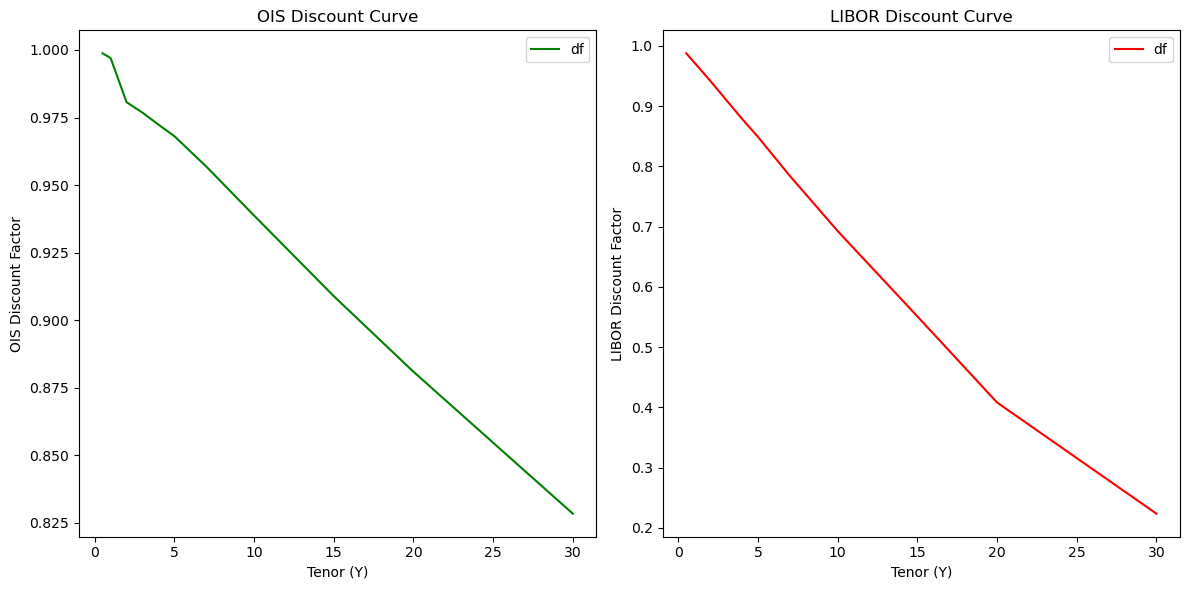

In [88]:
fig,axes=plt.subplots(1,2,figsize=(12,6))
ois_data.plot(x="years",y="df",ax=axes[0],color="Green")
axes[0].set_xlabel("Tenor (Y)")
axes[0].set_ylabel("OIS Discount Factor")
axes[0].set_title("OIS Discount Curve")
irr_data.plot(x="years",y="df",ax=axes[1],color="Red")
axes[1].set_xlabel("Tenor (Y)")
axes[1].set_ylabel("LIBOR Discount Factor")
axes[1].set_title("LIBOR Discount Curve")
plt.tight_layout()
plt.show()

In [90]:
def swap_pv01(Tn, N, freq):
    Do = ois_df
    TN = Tn + N
    dc = 1.0/freq # day count fraction
    return dc * (Do(np.arange(TN,Tn,-dc)).sum())

def swap_curve(Tn, N, freq):
    Do = ois_df
    D = libor_df
    TN = Tn + N
    PV01 = swap_pv01(Tn, N, freq)
    dc = 1.0/freq # day count fraction
    PV_flt = sum([Do(i)*(D(i-dc)-D(i))/D(i) if i>dc \
                  else Do(i)*(1-D(i))/D(i) \
                  for i in np.arange(TN,Tn,-dc)])
    return PV_flt / PV01

In [92]:
pv01 = pd.DataFrame(index=[1,5,10]
                        , columns=[1,2,3,5,10])
for r in pv01.index:
    for c in pv01.columns:
        pv01.at[r, c] = swap_pv01(r, c, freq=2)
pv01

,1,2,3,5,10
1,0.9944,1.985294,2.972386,4.93407,9.747887
5,0.978517,1.952145,2.920444,4.840612,9.542492
10,0.951722,1.897771,2.838147,4.70188,9.264214


In [94]:
swap_rates = pd.DataFrame(index=[1,5,10]
                        , columns=[1,2,3,5,10])
for r in swap_rates.index:
    for c in swap_rates.columns:
        swap_rates.at[r, c] = swap_curve(r, c, freq=2)
swap_rates

,1,2,3,5,10
1,0.032007,0.033259,0.034011,0.035255,0.038428
5,0.039274,0.040075,0.040072,0.041093,0.043634
10,0.042189,0.043116,0.044097,0.046249,0.053458
